## Inferring loss function from training trajectory

Joint work with Sam Laf.


### Research question
Can we use the weight change information during training to infer the nature of the loss function?

Formally, we're given the value of learning parameters in each training iteration $\theta_i, i \in \{1, 2, ..., T\}$, what can we say about the nature of the loss function?

Alternatively, this can be seen as we are given n points and their vector fields (graident direction): $(\theta_i, \triangledown_\theta L(\theta)|_{\theta=\theta_i}) $ for $i = {1,..., T-1}$. We want to infer which is the cost function used for optimization.

### Assumptions and details

Here, we make the following assumption for the experiments in this notebook. 
- First, we assume that the gradient of the parameters is of the following form (first order in it's parameters). Note that $\theta \in  \{w,b\}$. 
\begin{equation}
\triangledown_\theta L(\theta) = A \theta + B
\end{equation}

\begin{equation}
\triangledown_\theta L(\theta) = \begin{pmatrix}
\partial L/\partial w\\ 
\partial L/\partial b
\end{pmatrix} = A_{2\times 2} \begin{pmatrix}
w\\ 
b
\end{pmatrix} + B_{2 \times 1}
\end{equation}
- We fit a linear network to learn the values $A$ and $B$.
- The network learns using full batch gradient descent
- Learning rate is needed to reconstruct the loss function to scale. Without it, we can still reconstruct it but it will be off by a factor.
- We get the loss function by integrating the gradient
\begin{equation}
L(\theta) = \frac{1}{2} \theta^T A \theta + \theta^T B
\end{equation}

### Possible extensions
- Be able to identify different types of loss fucntions. 
- 

### Results

We were able to demonstrate that we can reconstruct the loss from the vector field under certain assumptions.

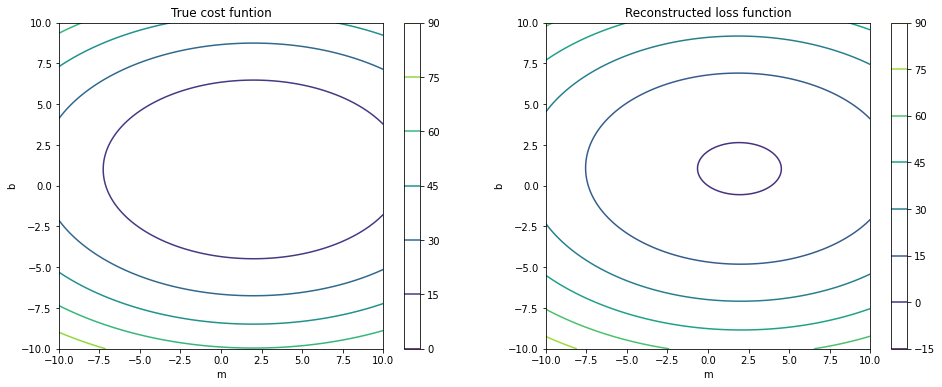

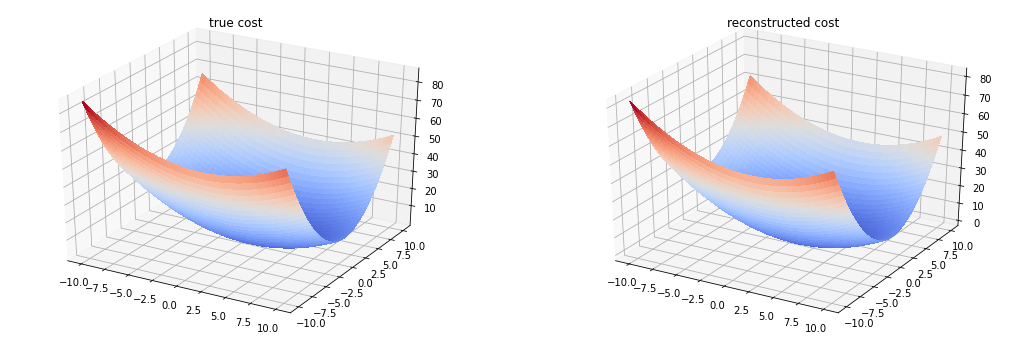

### Creating the dataset to work on

#### Setting things up

In [ ]:
# Importing required libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn 
import torch.nn.functional as F

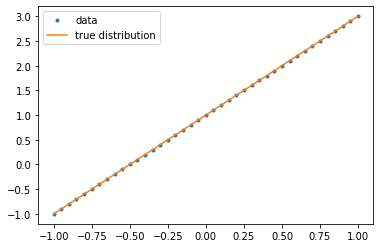

(<matplotlib.legend.Legend at 0x7f19bb4c24a8>, None)

In [ ]:
# Generating the data
x = np.arange(-1, 1.01, .05)
noise = np.random.randn(x.shape[0])
f_true = 2 * x + 1
y = f_true

# Plotting the data
plt.plot(x, y, '.', label='data')
plt.plot(x, f_true, '-', label='true distribution')
plt.legend(), plt.show()

In [ ]:
# Create a pytorch class for a linear network 
class LinearNet(nn.Module):
  def __init__(self, in_size=1, out_size=1):
    super(LinearNet, self).__init__()
    self.layer = nn.Linear(in_size, out_size)

    # Setting init parameters of the network
    self.layer.weight.data.fill_(0)
    self.layer.bias.data.fill_(0)

  def forward(self, x):
    y = self.layer(x)
    return y

#### Training a linear network and recording the trajectory


data shapes:  torch.Size([41, 1]) torch.Size([41, 1])
2.0989455833120285e-12


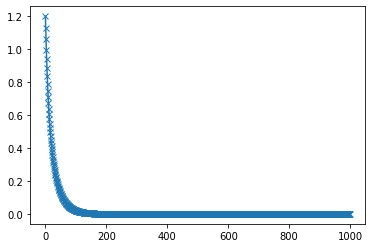

In [ ]:
x_torch = torch.from_numpy(x.T).unsqueeze(1).float()
y_torch = torch.from_numpy(y).unsqueeze(1).float()
print('data shapes: ', x_torch.size(), y_torch.size())

# Learn the network on the dataset
model = LinearNet()
optimizer = torch.optim.SGD(model.parameters(), lr=5e-2)
loss_vec = []
weights = []
weight_grads = []
max_iters = 1000

for t in range(max_iters):
    
    y_pred = model(x_torch)

    # Compute and print loss
    loss = (y_pred - y_torch).pow(2).mul(0.5).mean()
    
    loss_vec.append(loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Storing data into a dataset
    weights.append([model.layer.weight[0][0].tolist(), model.layer.bias[0].tolist()])
    grad_w = model.layer.weight.grad.numpy()[0][0] # Storing gradient for w
    grad_b = model.layer.bias.grad.numpy()[0] # Storing gradient for b
    weight_grads.append([grad_w, grad_b])
    
    
loss_vec = np.array(loss_vec)
weights = np.array(weights)
weight_grads = np.array(weight_grads)

plt.plot(loss_vec, '-x')
print(loss_vec[-1])

#### Visualizing trajectories of the trained network: Sanity checks

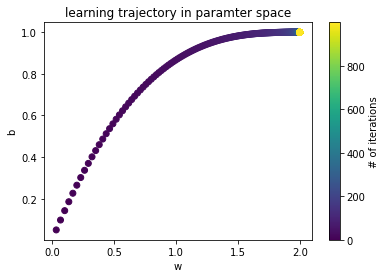

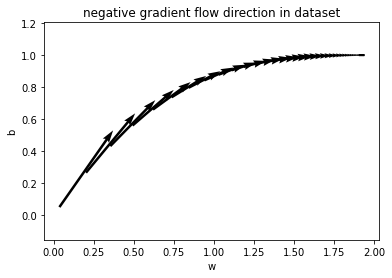

(Text(0.5, 17.200000000000003, 'w'), Text(17.200000000000003, 0.5, 'b'), None)

In [ ]:
# Plot the countour of loss function
plt.scatter(weights[:,0], weights[:,1], c=np.arange(max_iters))
cbar = plt.colorbar()
cbar.set_label('# of iterations', rotation=90)
plt.xlabel('w'), plt.ylabel('b'), plt.title('learning trajectory in paramter space'), plt.show()

# Quiver plot of the flow
clip = 200
jump = 5
plt.quiver(weights[:clip:jump,0], weights[:clip:jump,1], -weight_grads[:clip:jump,0], -weight_grads[:clip:jump,1])
plt.axis('equal'), plt.title('negative gradient flow direction in dataset')
plt.xlabel('w'), plt.ylabel('b'), plt.show()

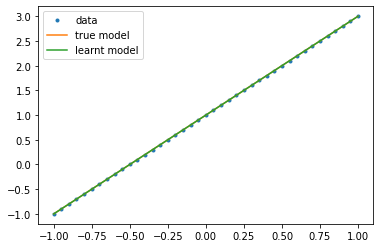

(<matplotlib.legend.Legend at 0x7f19b7674668>, None)

In [ ]:
plt.plot(x, y, '.', label='data')
plt.plot(x, f_true, '-', label='true model')
plt.plot(x, model(x_torch).detach().numpy().flatten(), label='learnt model')
plt.legend(), plt.show()

### Using the dataset to reconstruct the loss function

- The weights are stored in `weights` and gradients in `weight_grads`. 
- We assume a simple model of the dynamics where `weight_grads = A * weights + b`.
- This is similar to c(x) = A * x + b; we use a neural network to learn these

#### Training a linear network to learn this mapping

Problem: We need to make sure the loss goes really low! Even 99% close to optimal is not enough.


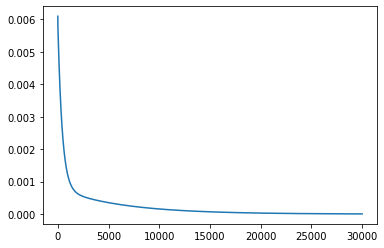

In [ ]:
# weights, weight_grads --> values of weights and their vector fields. 
model_c = LinearNet(in_size=2, out_size=2)
optimizer = torch.optim.SGD(model_c.parameters(), lr=1e-1)
loss_vec = []
max_iters2 = 30000

for t in range(max_iters2):
    
    y_pred = model_c(torch.tensor(weights).float())

    # Compute and print loss
    loss = (y_pred - torch.tensor(weight_grads).float()).pow(2).mul(0.5).mean()
    
    loss_vec.append(loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plt.plot(loss_vec)

#### Visualizing learnt gradients: sanity check

A =  [[ 0.36090663 -0.01863439]
 [ 0.02717784  0.94425327]] 
B =  [[-0.7029931 ]
 [-0.99752796]]


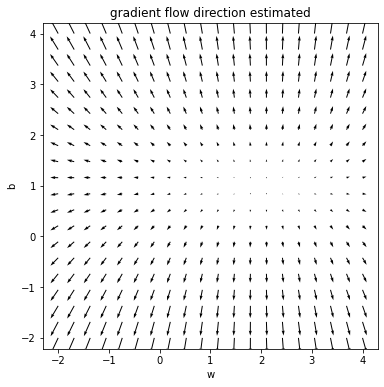

(Text(0.5, 17.200000000000003, 'w'), Text(17.200000000000003, 0.5, 'b'), None)

In [ ]:
# Estimating loss function from A matrix
A_est = model_c.layer.weight.data.numpy() # CHECK: dimensions here
b_est = model_c.layer.bias.data.numpy().reshape(2,1)

print('A = ', A_est, '\nB = ', b_est)

# Reconstructing the vector field
start, stop, n_values = -2, 4, 20

x_vals = np.linspace(start, stop, n_values)
y_vals = np.linspace(start, stop, n_values)
m, b = np.meshgrid(x_vals, y_vals)

grads = model_c(torch.Tensor(np.concatenate((m.reshape((n_values**2,-1)),b.reshape((n_values**2,-1))),axis=1)).float())
grads = grads.detach().numpy()

plt.figure(figsize=(6,6))
plt.quiver(m, b, grads[:,0], grads[:,1])
plt.axis('equal'), plt.title('gradient flow direction estimated')
plt.xlabel('w'), plt.ylabel('b'), plt.show()

### Visualizing the loss functions

#### Creating true loss function from data


In [ ]:
# Estimating the loss from data by using symbolic variable processing
import sympy as sym
m = sym.Symbol('m')
b = sym.Symbol('b')
true_loss = sym.Rational(0, 1)
for i in range(x.shape[0]):
  true_loss = true_loss + 0.5 * (y[i] - m * x[i] - b) ** 2
sym.expand(true_loss/x.shape[0])

# true_loss2 = (y - (2*x + 1))**2

0.5*b**2 + 9.43689570931383e-16*b*m - 1.0*b + 0.175*m**2 - 0.700000000000002*m + 1.2

#### Creating estimated loss function from linear network weights

In [ ]:
m = sym.Symbol('m')
b = sym.Symbol('b')
symx = sym.Matrix([[m],[b]])
symx_t = sym.Matrix([[m, b]])
# b_est = np.array([[0],[0]])
est_loss = 0.5 * (symx_t * A_est * symx) + (symx_t * b_est)
sym.expand(est_loss[0,0])

0.472126662731171*b**2 + 0.00427172146737576*b*m - 0.997528*b + 0.180453300476074*m**2 - 0.702993*m

#### Visualizing both loss functions


true minimum:  1.989987484355444 0.9887359198998755 8.098358241714898e-05
reconstructed minimum:  1.9399249061326653 1.0387984981226523 -1.202801440776173


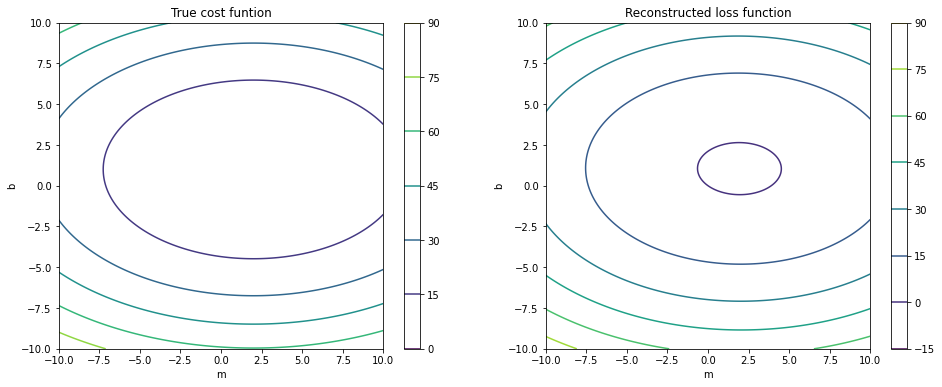

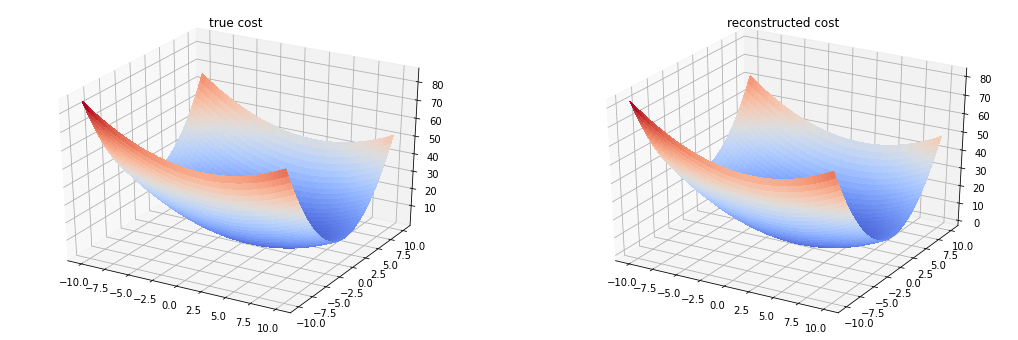

In [ ]:
def returnMinIndices(mat,n_values=800):
  return (int(np.floor(np.argmin(mat)/n_values)), np.argmin(mat)%n_values)

start, stop, n_values = -10, 10, 800

x_vals = np.linspace(start, stop, n_values)
y_vals = np.linspace(start, stop, n_values)
m, b = np.meshgrid(x_vals, y_vals)


Z1 = 0.5*b**2 + 9.43689570931383e-16*b*m - 1.0*b + 0.175*m**2 - 0.700000000000002*m + 1.2
Z2 = 0.472126662731171*b**2 + 0.00427172146737576*b*m - 0.997528*b + 0.180453300476074*m**2 - 0.702993*m
# Z2 = (m-1)**2 + (b-2)**2
# Z2 = 0.2*m**2 - 0.6*m +0.25*b**2 - 0.8*m
print('true minimum: ', m[returnMinIndices(Z1)], b[returnMinIndices(Z1)], Z1[returnMinIndices(Z1)])
print('reconstructed minimum: ', m[returnMinIndices(Z2)], b[returnMinIndices(Z2)], Z2[returnMinIndices(Z2)])

plt.figure(figsize=(16,6))
ax = plt.subplot(121)
cp = plt.contour(m, b, Z1)
plt.colorbar(cp)
plt.axis('equal')
ax.set_title('True cost funtion')
ax.set_xlabel('m')
ax.set_ylabel('b')

ax = plt.subplot(122)
cp = plt.contour(m, b, Z2)
plt.colorbar(cp)
plt.axis('equal')
ax.set_title('Reconstructed loss function')
ax.set_xlabel('m')
ax.set_ylabel('b')
plt.show()


# Generating some normal plots
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(m, b, Z1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
plt.title('true cost')

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_surface(m, b, Z2, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
plt.title('reconstructed cost'); plt.show()